# Building Custom Optimizer

We give a tutorial on how to build custom optimizers in Trace. We will demonstrate how the classical back-propagation and gradient descent algorithms can be implemented in Trace as an optimizer. We will show two ways to do this. The first is through implementing the back-propagation algorithm within the Trace optimzier, which operates on Trace graph. The second is to overload the propagator to propagate gradeints directly in Trace, instead of Trace graph. This example shows the flexibilty of the Trace framework.

### Basic back-propagation and gradient descent with PyTorch

To start, let's define a simple objective and run vanilla gradient descent to optimize the variable in pytorch. This code will be used as the reference of desired behaviors. We make the code below transparent for tutorial purppose, so we use the `torch.autograd.grad` api and write down the gradient descent update rule manually.

In [ ]:
%pip install trace-opt
%pip install torch

In [2]:
import torch

stepsize = 0.1
print('Vanilla gradient descent implementation using PyTorch')
param  = torch.tensor(1.0, requires_grad=True)  # this is the param we optimize
def forward():
    x = param
    return torch.abs(x) + torch.square(x) * torch.tensor(0.5, requires_grad=True)
for i in range(10):
    y = forward()
    g = torch.autograd.grad(y, [param], torch.tensor(1.0))
    param = param - stepsize * g[0]
    print(f'  Loss at iter {i}: {y.data}')


Vanilla gradient descent implementation using PyTorch
  Loss at iter 0: 1.5
  Loss at iter 1: 1.1200000047683716
  Loss at iter 2: 0.8122000098228455
  Loss at iter 3: 0.5628820061683655
  Loss at iter 4: 0.36093443632125854
  Loss at iter 5: 0.19735687971115112
  Loss at iter 6: 0.0648590698838234
  Loss at iter 7: 0.04434824362397194
  Loss at iter 8: 0.06279093772172928
  Loss at iter 9: 0.046178679913282394


### Set up the objective in Trace

After seeing how ideally basic gradient descent + back-propagation behaves, next we show how it can be implemented it in Trace. To this end, we need to turn each math ops used in the above loss as a `bundle`, and define the parameter as a `node`. In this way, Trace can create a computational graph (DAG) of the workflow of computing the objective. We visualize the DAG below.

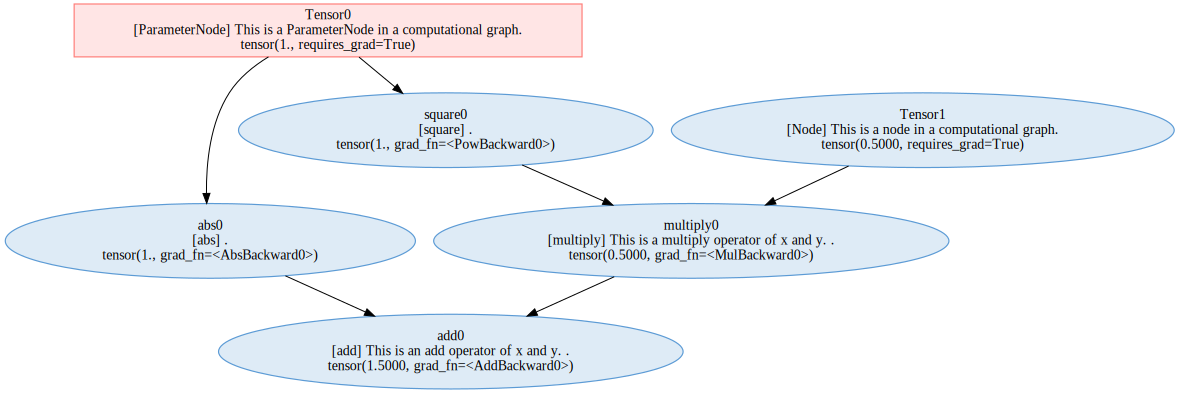

In [3]:
from opto.trace import bundle, node
from opto.trace.propagators.propagators import Propagator

@bundle()
def abs(x):
    return torch.abs(x)

@bundle()
def square(x):
    return torch.square(x)

param  = node(torch.tensor(1.0, requires_grad=True), trainable=True)
def forward():
    x = param
    return abs(x) + square(x) * torch.tensor(0.5, requires_grad=True)

forward().backward(visualize=True)

### Version 1 Trace Implementation based on Optimizer

The first way is to implement the back-propagation algorithm as part of the optimizer in Trace. By default, optimzers in Trace receive the propagated Trace graph at the parameter nodes. Trace graph is a generalization of gradient. Here we show how we can implement back-propagation on the Trace graph to recover the propagated gradient and use it for gradient descent. We can see the loss sequence here matches what we had above implemented by PyTorch.


In [4]:
from opto.optimizers.optimizer import Optimizer
from collections import defaultdict


class BackPropagationGradientDescent(Optimizer):

    def __init__(self, parameters, stepsize, *args, **kwargs):
        super().__init__(parameters, *args, **kwargs)
        self.stepsize = stepsize

    def _step(self, *args, **kwargs):
        """Return the new data of parameter nodes based on the feedback."""
        trace_graph = self.trace_graph   # aggregate the trace graphes into one.
        grads = defaultdict(lambda: torch.tensor(0.0))
        # trace_graph.graph is a list of nodes sorted according to the topological order
        for i, ( _, x) in enumerate(reversed(trace_graph.graph)):  # back-propagation starts from the last node
            if len(x.parents) == 0:
                continue
            g = trace_graph.user_feedback if i == 0 else grads[x]
            propagated_grads = torch.autograd.grad(x.data,  [p.data for p in x.parents], g)  # propagate the gradient
            for p, pg in zip(x.parents, propagated_grads):
                grads[p] += pg  #  accumulate gradient
        return {p: p.data - self.stepsize * grads[p] for p in self.parameters}  # propose new update



bp = BackPropagationGradientDescent([param], stepsize=stepsize)
print('Version 1 gradient descent implementation using Trace')

for i in range(10):
    y = forward()
    bp.zero_feedback()
    bp.backward(y, torch.tensor(1.0))
    bp.step()
    print(f'  Loss at iter {i}: {y.data}')


Version 1 gradient descent implementation using Trace
  Loss at iter 0: 1.5
  Loss at iter 1: 1.1200000047683716
  Loss at iter 2: 0.8122000098228455
  Loss at iter 3: 0.5628820061683655
  Loss at iter 4: 0.36093443632125854
  Loss at iter 5: 0.19735687971115112
  Loss at iter 6: 0.0648590698838234
  Loss at iter 7: 0.04434824362397194
  Loss at iter 8: 0.06279093772172928
  Loss at iter 9: 0.046178679913282394


### Version 2 Trace Implementation based on Propagator + Optimizer

Another way is to override the what's propagated in the `backward` call of Trace. Trace has a generic backward routine performed on the computational graph that can support designing new end-to-end optimization algorithms. While by default Trace propagates Trace graphes in `backward` for generality, for the differentiable problems here we can override the behavior and let it directly propagate gradients. In this way, the optimizer would receive directly the propagted gradient instead of Trace graphs.


In [5]:

print('Implementation by Propagator')


# We create a custom propagator that back-propagates the gradient
class BackPropagator(Propagator):

    def init_feedback(self, node, feedback):
        return feedback

    def _propagate(self, child):
        grad = sum(sum(v) for v in child.feedback.values())
        propagated_grads = torch.autograd.grad(child.data,  [p.data for p in child.parents], grad)
        return {p: pg for p, pg in zip(child.parents, propagated_grads)}


class GradientDescent(Optimizer):

    def __init__(self, parameters, stepsize, *args, **kwargs):
        super().__init__(parameters, *args, **kwargs)
        self.stepsize = stepsize

    def default_propagator(self):
        # use the custom propagator instead of the default one, which propagates Trace graph
        return BackPropagator()

    def _step(self, *args, **kwargs):
        # simpel gradient descent
        return {p: p.data - self.stepsize * sum(sum(v) for v in p.feedback.values()) for p in self.parameters}  # propose new update



param  = node(torch.tensor(1.0, requires_grad=True), trainable=True)  # reset
bp = GradientDescent([param], stepsize=stepsize)
print('Version 2 gradient descent implementation using Trace')

for i in range(10):
    y = forward()
    bp.zero_feedback()
    bp.backward(y, torch.tensor(1.0))
    bp.step()
    print(f'  Loss at iter {i}: {y.data}')


Implementation by Propagator
Version 2 gradient descent implementation using Trace
  Loss at iter 0: 1.5
  Loss at iter 1: 1.1200000047683716
  Loss at iter 2: 0.8122000098228455
  Loss at iter 3: 0.5628820061683655
  Loss at iter 4: 0.36093443632125854
  Loss at iter 5: 0.19735687971115112
  Loss at iter 6: 0.0648590698838234
  Loss at iter 7: 0.04434824362397194
  Loss at iter 8: 0.06279093772172928
  Loss at iter 9: 0.046178679913282394
